In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import pandas as pd

from dotenv import load_dotenv, find_dotenv
from pathlib import Path

from src.data.rgbd import load_rgbd
from src.data.pcd import load_pcd
from src.features.cropping import mask_selection_volume, box_mask_from_rgbd
from src.features.voxels import voxel2np

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
project_dir = Path(dotenv_path).parent

# load up the entries as environment variables
load_dotenv(dotenv_path)

o3d.visualization.webrtc_server.enable_webrtc()

[Open3D INFO] WebRTC GUI backend enabled.


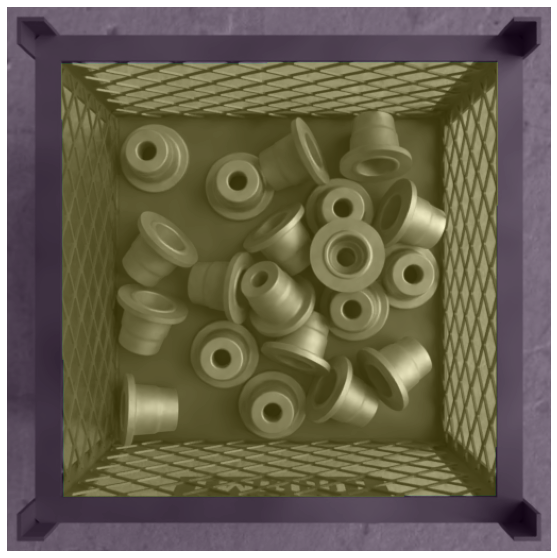

In [10]:
%matplotlib inline

raw_data_dir = project_dir/'data/raw/render_results_imov_cam_mist_simple'

img_fpath = np.random.choice(list(raw_data_dir.glob('*/*.exr')))

rgbd = load_rgbd(img_fpath)

box_mask = box_mask_from_rgbd(rgbd)

plt.imshow(rgbd.color, cmap='gray')
plt.imshow(box_mask, alpha=0.2)
plt.gcf().set_size_inches(10,10)
plt.gca().set_axis_off()
plt.show()

In [11]:
vol = mask_selection_volume(rgbd, box_mask)

pcd = load_pcd(rgbd)

box = vol.crop_point_cloud(pcd)

box

PointCloud with 79802 points.

In [57]:
# voxel_size = 0.005
voxel_size = 0.01

box_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(box, voxel_size)

# get grid shape and position
grid_pos = box_voxel.get_min_bound()
# grid_pos[-1] = 0.1288  # floor
grid_pos[-1] = 0.1088  # floor

grid_shape = (box_voxel.get_max_bound() - grid_pos) / box_voxel.voxel_size
grid_shape = (grid_shape + 0.5).astype(int)

box_grid = voxel2np(box_voxel, grid_pos, grid_shape)

box_grid.shape

(55, 55, 46)

In [58]:
%matplotlib widget

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(box_grid, facecolors='gray')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [59]:
voxel_size = 0.005

box_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(box, voxel_size)

# get grid shape and position
grid_pos = box_voxel.get_min_bound()
grid_pos[-1] = 0.1088  # floor

grid_shape = (box_voxel.get_max_bound() - grid_pos) / box_voxel.voxel_size
grid_shape = (grid_shape + 0.5).astype(int)

box_grid = voxel2np(box_voxel, grid_pos, grid_shape)

box_grid.shape

(108, 108, 92)

In [64]:
box_grid.sum() * (voxel_size ** 3)

0.0178745

In [ ]:
from tqdm.notebook import tqdm

voxel_size = 0.005

# vols = dict()
with open('vols.json', 'r') as f:
    vols = json.load(f)

In [116]:
for img_fpath in tqdm(list(raw_data_dir.glob('*/*.exr'))):
    if img_fpath.name in vols.keys():
        continue
    if img_fpath == Path('/home/ctc_das/Desktop/part_counting/data/raw/render_results_imov_cam_mist_simple/simulacao120/simulacao120_0098.exr'):
        continue

    rgbd = load_rgbd(img_fpath)

    box_mask = box_mask_from_rgbd(rgbd)

    vol = mask_selection_volume(rgbd, box_mask)

    pcd = load_pcd(rgbd)

    box = vol.crop_point_cloud(pcd)
    
    box_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(box, voxel_size)

    # get grid shape and position
    grid_pos = box_voxel.get_min_bound()
    grid_pos[-1] = 0.1088  # floor

    grid_shape = (box_voxel.get_max_bound() - grid_pos) / box_voxel.voxel_size
    grid_shape = (grid_shape + 0.5).astype(int)

    box_grid = voxel2np(box_voxel, grid_pos, grid_shape)
    
    vols[img_fpath.name] = box_grid.sum() * (voxel_size ** 3)

  0%|          | 0/8353 [00:00<?, ?it/s]

In [118]:
with open('vols.json', 'w') as f:
    json.dump(vols, f)

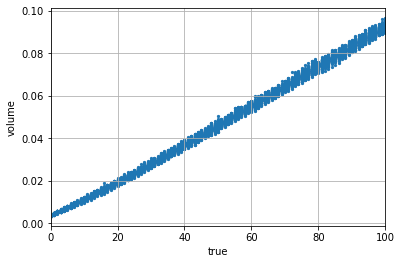

In [169]:
%matplotlib inline

ys = np.array([int(y.split('_')[-1].split('.')[0]) for y in vols.keys()])
volumes = np.array(list(vols.values()))

df = pd.DataFrame([ys, volumes]).T
df.columns = ['true', 'volume']

plt.scatter(ys, volumes, s=5)

plt.ylabel('volume')
plt.xlabel('true')

plt.xlim(0,100)
plt.grid()
plt.show()

<AxesSubplot:xlabel='true'>

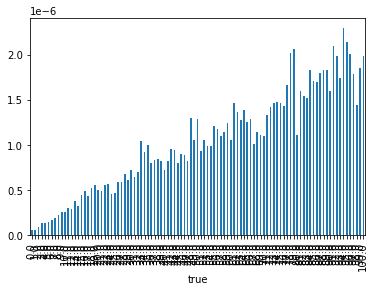

In [173]:
df.groupby('true')['volume'].var().plot(kind='bar')

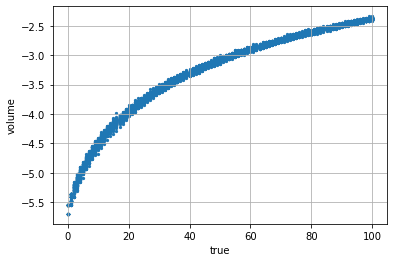

In [174]:
%matplotlib inline

df['log_volume'] = df['volume'].apply(np.log)

plt.scatter(df['true'], df['log_volume'], s=5)

plt.ylabel('volume')
plt.xlabel('true')

# plt.xlim(0,100)

# plt.yscale('log')
plt.grid()
plt.show()

<AxesSubplot:xlabel='true'>

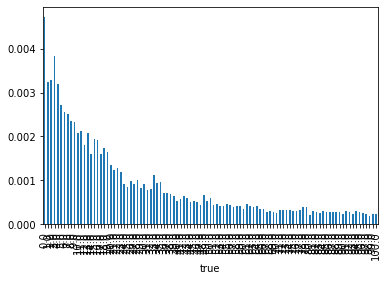

In [175]:
df.groupby('true')['log_volume'].var().plot(kind='bar')

In [172]:
df.groupby('true').count().min(), df.groupby('true').count().max()

(volume    81
 dtype: int64,
 volume    83
 dtype: int64)

In [122]:
import scipy as sp

sp.stats.pearsonr(ys, volumes)

(0.9988906439062779, 0.0)

(-1.488253262803589, array([1104.9718967]))


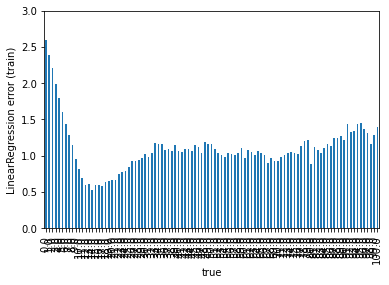

In [193]:
from sklearn.linear_model import LinearRegression

X = volumes.reshape(-1, 1)
y = ys

lr = LinearRegression()

lr = lr.fit(X, y)

print((lr.intercept_, lr.coef_))

df['lin_pred'] = lr.predict(X)
df['lin_error'] = (df['true'] - df['lin_pred']).abs()
df.groupby('true')['lin_error'].mean().plot(kind='bar')

plt.ylim(0,3)
plt.ylabel('LinearRegression error (train)')
plt.show()

In [195]:
from joblib import dump

with open(project_dir/'models/linear_regression.pkl', 'wb') as f:
    dump(lr, f)

[-1228.28177527  1221.51008375    -3.40037744]


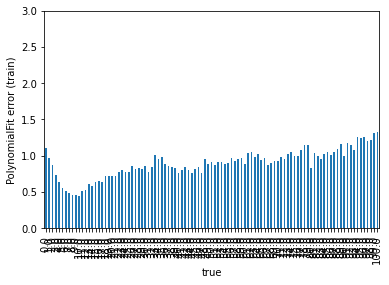

In [194]:
p = np.polyfit(df['volume'], df['true'], 2)
print(p)
poly = lambda x: p[0] * x**2 + p[1] * x + p[-1]

df['poly_pred'] = df['volume'].apply(poly)
df['poly_error'] = (df['true'] - df['poly_pred']).abs()
df.groupby('true')['poly_error'].mean().plot(kind='bar')


plt.ylim(0,3)
plt.ylabel('PolynomialFit error (train)')
plt.show()

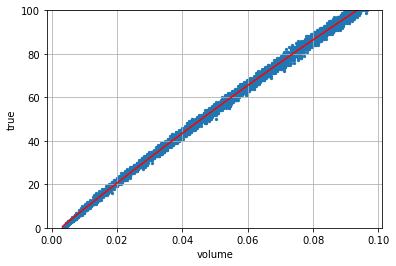

In [177]:
%matplotlib inline

plt.scatter(volumes, ys, s=5)

x_sample = np.linspace(df['volume'].min(), df['volume'].max())
plt.plot(x_sample, poly(x_sample), c='red')

plt.xlabel('volume')
plt.ylabel('true')

plt.ylim(0,100)
plt.grid()
plt.show()

In [198]:
with open(project_dir/'models/polynomial_fit.pkl', 'wb') as f:
    dump(p, f)